# Pairwise MLP with PU

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- cone around the candidate trackster


## MLP

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from reco.loss import FocalLoss

from reco.datasetPU import TracksterPairsPU


ds_name = "CloseByGamma200PUFull"
data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
ds = TracksterPairsPU(
    ds_name,
    data_root,
    raw_dir,
)

ds.x.shape
ds.processed_file_names

['TracksterPairsPU_CloseByGamma200PUFull_f9_r10_s0.2.pt']

In [5]:
scaler = StandardScaler()
scaler.fit(ds.x)
ds.x = torch.tensor(scaler.transform(ds.x)).type(torch.float)

In [6]:
print(ds.x.shape)
print("Positive:", int((ds.y > 0.5).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.5).type(torch.int).sum()))

torch.Size([3228, 43])
Positive: 229
Negative: 2999


In [7]:
balance =  float(sum(ds.y) / len(ds.y))
print(f"dataset balance: {balance*100:.2f}% / {(1-balance)*100:.2f}%") 

dataset balance: 9.83% / 90.17%


In [8]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 2906, Test samples: 322


In [9]:
def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        labels_acc = (labels > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == labels_acc)
    return (correct / total)

In [10]:
model = nn.Sequential(
    nn.Linear(ds.x.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
loss_obj = FocalLoss(alpha=1-balance, gamma=2)

epochs = 101

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_acc = test(model, train_dl)
    test_acc = test(model, test_dl)
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

Epoch: 0, loss: 0.4355, train acc: 0.9291, test acc: 0.9286
Epoch: 5, loss: 0.1715, train acc: 0.9639, test acc: 0.9503
Epoch: 10, loss: 0.1431, train acc: 0.9714, test acc: 0.9658
Epoch: 15, loss: 0.1579, train acc: 0.9769, test acc: 0.9658
Epoch: 20, loss: 0.1398, train acc: 0.9831, test acc: 0.9627
Epoch: 25, loss: 0.1343, train acc: 0.9814, test acc: 0.9534
Epoch: 30, loss: 0.1329, train acc: 0.9855, test acc: 0.9658
Epoch: 35, loss: 0.1403, train acc: 0.9849, test acc: 0.9534
Epoch: 40, loss: 0.1224, train acc: 0.9880, test acc: 0.9565
Epoch: 45, loss: 0.1322, train acc: 0.9876, test acc: 0.9565
Epoch: 50, loss: 0.1258, train acc: 0.9880, test acc: 0.9503
Epoch: 55, loss: 0.1236, train acc: 0.9883, test acc: 0.9627
Epoch: 60, loss: 0.1256, train acc: 0.9914, test acc: 0.9565
Epoch: 65, loss: 0.1159, train acc: 0.9907, test acc: 0.9565
Epoch: 70, loss: 0.1274, train acc: 0.9900, test acc: 0.9534
Epoch: 75, loss: 0.1179, train acc: 0.9890, test acc: 0.9596
Epoch: 80, loss: 0.1303, t

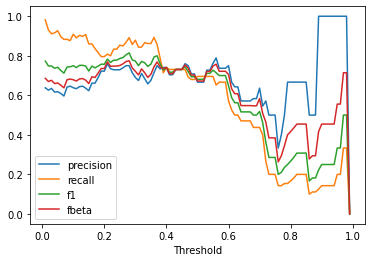

In [11]:
th_values = [i / 100. for i in range(1, 100)]
precision = []
recall = []
f1scores = []
fbeta = []

for th in th_values:
    pred = []
    lab = []
    for b, l in test_dl:
        b = b.to(device)
        l = l.to(device)
        pred += (model(b) > th).type(torch.int).tolist()
        lab += (l > th).type(torch.int).tolist()
    precision.append(precision_score(lab, pred, zero_division=0))
    recall.append(recall_score(lab, pred))
    f1scores.append(f1_score(lab, pred))
    fbeta.append(fbeta_score(lab, pred, beta=0.5))

plt.figure()
plt.plot(th_values, precision, label="precision")
plt.plot(th_values, recall, label="recall")
plt.plot(th_values, f1scores, label="f1")
plt.plot(th_values, fbeta, label="fbeta")
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [12]:
decision_th = th_values[np.argmax(fbeta)]

pred = []
lab = []
for b, l in test_dl:
    b = b.to(device)
    l = l.to(device)
    pred += (model(b) > decision_th).type(torch.int).tolist()
    lab += (l > th).tolist()

tn, fp, fn, tp = confusion_matrix(lab, pred).ravel()
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
acc = accuracy_score(lab, pred)
precision = precision_score(lab, pred)
recall = recall_score(lab, pred)
f1 = f1_score(lab, pred)
fb = fbeta_score(lab, pred, beta=0.5)
print(f'TH: {decision_th} Acc: {acc:.3f} P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} FB: {fb:.3f}')

TP: 2, TN: 278, FP: 42, FN: 0
TH: 0.28 Acc: 0.870 P: 0.045 R: 1.000 F1: 0.087 FB: 0.056


# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [4]:
import uproot
import numpy as np
from reco.evaluation import evaluate

file_name = f"{raw_dir}/new_ntuples_15295178_22.root"
tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})